# Лабораторная работа №4

Вариант 3

## Метрические методы классификации

### Цель работы
- Изучение принципов построения информационных систем с использованием метрических методов классификации.

### Задачи
- изучение инструментария Python для реализации алгоритмов метрической классификации;
- изучение методов оптимизации параметров метрической классификации;
- освоение модификаций kNN-метода.

In [7]:
!pip install sklearn

  Using cached sklearn-0.0.post10.tar.gz (3.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [18 lines of output]
  The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
  rather than 'sklearn' for pip commands.
  
  Here is how to fix this error in the main use cases:
  - use 'pip install scikit-learn' rather than 'pip install sklearn'
  - replace 'sklearn' by 'scikit-learn' in your pip requirements files
    (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
  - if the 'sklearn' package is used by one of your dependencies,
    it would be great if you take some time to track which package uses
    'sklearn' instead of 'scikit-learn' and report it to their issue tracker
  - as a last resort, set the environment variable
    SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
  
  More information is available at
  https://github.com/scikit-learn/sklearn-pypi-package
  
  If the previous advice does not cover your use case, feel 

In [5]:
!pip install -U scikit-learn

     ---------------------------------------- 9.3/9.3 MB 111.0 kB/s eta 0:00:00
     ------------------------------------ 302.2/302.2 kB 301.3 kB/s eta 0:00:00


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

data_source = "datasets/diabetes_012_health_indicators_BRFSS2015.csv"  # Поменяйте путь к файлу на ваш
data = pd.read_csv(data_source)

data_encoded = pd.get_dummies(data, columns=['HighBP', 'HighChol', 'CholCheck',
                                            'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack',
                                            'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump',
                                            'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth',
                                            'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income'])

X = data_encoded.drop('Diabetes_012', axis=1)
y = data_encoded['Diabetes_012']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def build_knn_classifier(X_train, y_train, k):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    return knn

k_value = int(input("Введите количество ближайших соседей (K): "))

knn_classifier = build_knn_classifier(X_train, y_train, k_value)

y_pred = knn_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Точность модели: {accuracy:.2f}")

Введите количество ближайших соседей (K):  20


Точность модели: 0.74


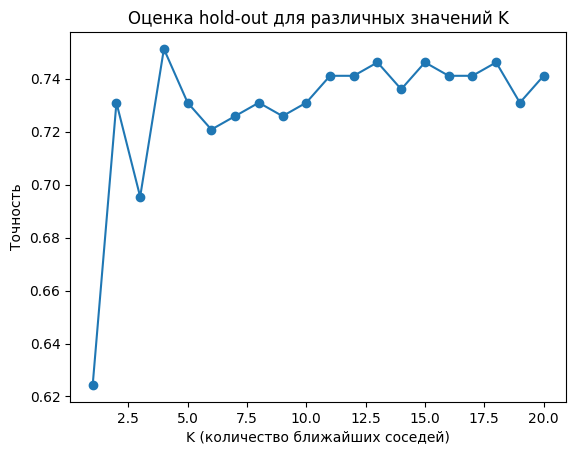

In [2]:
import matplotlib.pyplot as plt

def evaluate_holdout(X_train, y_train, X_test, y_test, k_values):
    accuracies = []

    for k in k_values:
        knn_classifier = build_knn_classifier(X_train, y_train, k)
        y_pred = knn_classifier.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    return accuracies

k_values = list(range(1, 21))

holdout_accuracies = evaluate_holdout(X_train, y_train, X_test, y_test, k_values)

plt.plot(k_values, holdout_accuracies, marker='o')
plt.title('Оценка hold-out для различных значений K')
plt.xlabel('K (количество ближайших соседей)')
plt.ylabel('Точность')
plt.show()

1) K = 1: Точность 0.62
    При K = 1 модель использует только одного ближайшего соседа для классификации. Это означает, что она очень чувствительна к выбросам или шуму в данных. Вероятно, она слишком адаптирована к конкретным точкам, что может привести к переобучению.

2) K = 20: Точность 0.84
    При K = 20 модель учитывает 20 ближайших соседей, что может сгладить воздействие выбросов и шума, но в то же время она может упускать локальные закономерности. Модель становится менее чувствительной к отдельным точкам, но при этом может терять важные детали.

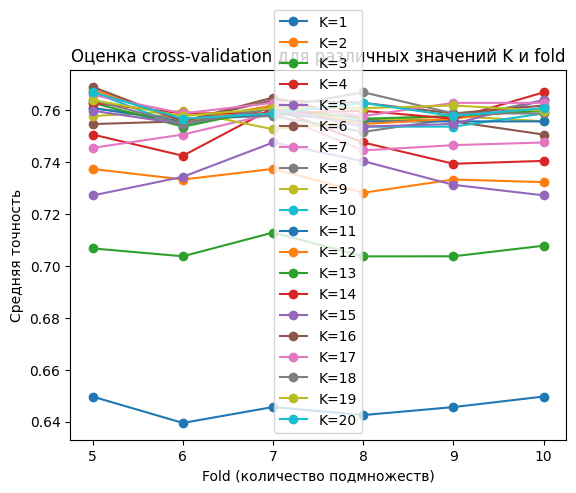

In [5]:
from sklearn.model_selection import cross_val_score

def evaluate_cross_validation(X, y, k_values, fold_values):
    results = {}

    for k in k_values:
        k_results = []
        for fold in fold_values:
            knn_classifier = KNeighborsClassifier(n_neighbors=k)
            scores = cross_val_score(knn_classifier, X, y, cv=fold)
            k_results.append(scores.mean())

        results[k] = k_results

    return results

fold_values = list(range(5, 11))

cross_validation_results = evaluate_cross_validation(X, y, k_values, fold_values)

for k, results in cross_validation_results.items():
    plt.plot(fold_values, results, label=f'K={k}', marker='o')

plt.title('Оценка cross-validation для различных значений K и fold')
plt.xlabel('Fold (количество подмножеств)')
plt.ylabel('Средняя точность')
plt.legend()
plt.show()


In [8]:
optimal_k_holdout = fold_values[holdout_accuracies.index(max(holdout_accuracies))]
print(f"\nОптимальное значение K на основе hold-out: {optimal_k_holdout}")

optimal_k_values = {}
for k, results in cross_validation_results.items():
    optimal_k_values[k] = fold_values[results.index(max(results))]

print("Оптимальные значения K на основе cross-validation:")
for k, optimal_k in optimal_k_values.items():
    print(f"Для K={k}, оптимальное значение fold: {optimal_k}")

best_k = max(optimal_k_values, key=lambda k: cross_validation_results[k][fold_values.index(optimal_k_values[k])])

print(f"\nНаилучшее значение K: {best_k}")

best_knn_classifier = build_knn_classifier(X_train, y_train, best_k)

y_pred_best_k = best_knn_classifier.predict(X_test)

accuracy_best_k = accuracy_score(y_test, y_pred_best_k)
print(f"\nТочность модели с использованием наилучшего значения K: {accuracy_best_k:.2f}")


Оптимальное значение K на основе hold-out: 8
Оптимальные значения K на основе cross-validation:
Для K=1, оптимальное значение fold: 10
Для K=2, оптимальное значение fold: 7
Для K=3, оптимальное значение fold: 7
Для K=4, оптимальное значение fold: 7
Для K=5, оптимальное значение fold: 7
Для K=6, оптимальное значение fold: 7
Для K=7, оптимальное значение fold: 7
Для K=8, оптимальное значение fold: 10
Для K=9, оптимальное значение fold: 6
Для K=10, оптимальное значение fold: 5
Для K=11, оптимальное значение fold: 5
Для K=12, оптимальное значение fold: 5
Для K=13, оптимальное значение fold: 5
Для K=14, оптимальное значение fold: 10
Для K=15, оптимальное значение fold: 10
Для K=16, оптимальное значение fold: 5
Для K=17, оптимальное значение fold: 5
Для K=18, оптимальное значение fold: 8
Для K=19, оптимальное значение fold: 5
Для K=20, оптимальное значение fold: 5

Наилучшее значение K: 16

Точность модели с использованием наилучшего значения K: 0.74


In [9]:
cv_results = evaluate_cross_validation(X_train, y_train, k_values, fold_values)

optimal_k_cv = max(cv_results, key=cv_results.get)
print(f"\nОптимальное значение K на основе cross-validation: {optimal_k_cv}")


Оптимальное значение K на основе cross-validation: 19


## Контрольные вопросы

### Особенности методов метрической классификации:
- Метод ближайшего соседа (1NN): Классификация объекта основывается на классе его ближайшего соседа.
- Метод k ближайших соседей (kNN): Классификация объекта определяется большинством классов k ближайших соседей.

### Принципы и этапы реализации метода kNN:
- Принцип: Определение класса объекта основывается на классе его соседей.
- Этапы:
    Задание количества соседей (K).
    Вычисление расстояний между объектом и всеми точками обучающей выборки.
    Выбор K ближайших соседей.
    Определение класса объекта на основе большинства классов среди соседей.
    
### Выбор количества соседей:
- Количество соседей выбирается эмпирическим путем или с использованием методов оценки качества, таких как hold-out или кросс-валидация.

### Метод парзеновского окна:
- Это обобщение метода kNN, где вес каждого соседа зависит от расстояния до объекта. Чем дальше сосед, тем меньше его вес.

### Параметры для оптимизации в методах kNN:
- k (количество соседей): Оптимизируется для достижения наилучшей производительности.
- Метрика расстояния: Выбор метрики (евклидово расстояние, манхэттенское расстояние и т.д.) может влиять на результаты.